In [ ]:
import tensorflow as tf
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
import tensorflow.keras.layers as layers
import PIL
from IPython import display
import os
import glob

In [ ]:
#We will be using cifar 10 and MNIST for this purpose

In [ ]:
dir(tf.keras.datasets)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'boston_housing',
 'cifar10',
 'cifar100',
 'fashion_mnist',
 'imdb',
 'mnist',
 'reuters']

In [ ]:
#MNIST
(images,labels),(_,_)=tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
images.shape

(60000, 28, 28)

In [ ]:
images = images.reshape(images.shape[0],28,28,1).astype('float32')

In [ ]:
images.shape

(60000, 28, 28, 1)

In [ ]:
import random

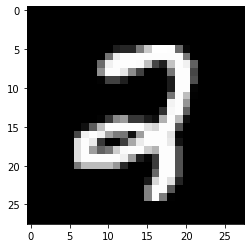

In [ ]:
plt.imshow(tf.squeeze(images[random.randint(0,60000)]),cmap="gray")

In [ ]:
images = (images - 127.5) / 127.5

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
train_dataset=tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(256)

In [ ]:
train_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [ ]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

In [ ]:
generator = generator_model()

In [ ]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)        

In [ ]:
noise = tf.random.normal([1,100])

In [ ]:
g_image = generator(noise)

In [ ]:
g_image.shape

TensorShape([1, 28, 28, 1])

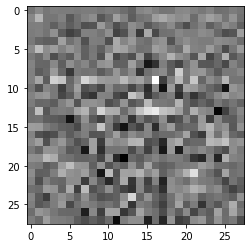

In [ ]:
plt.imshow(np.squeeze(g_image),cmap="gray")

In [ ]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = discriminator_model()

In [ ]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
re_lu (ReLU)                 (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [ ]:
print(discriminator(g_image))

tf.Tensor([[-0.00163463]], shape=(1, 1), dtype=float32)


In [ ]:
entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def loss(real,fake):
  loss1 = entropy(tf.ones_like(real),real)
  loss2 = entropy(tf.zeros_like(fake),fake)
  return loss1 + loss2

In [ ]:
def generator_loss(fake):
    return entropy(tf.ones_like(fake), fake)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
seed = tf.random.normal([16,100])

In [ ]:
seed

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[-2.4283996 ,  0.5609358 , -0.12110407, ...,  1.4389253 ,
        -0.13612314,  0.2704619 ],
       [-0.89911395, -0.68249154, -0.00382543, ...,  1.0218433 ,
        -1.7607249 ,  0.721101  ],
       [ 1.9704143 , -1.3250463 ,  0.00269905, ...,  1.2789851 ,
        -0.11949929,  0.4546842 ],
       ...,
       [ 2.246227  , -0.37350124, -0.30548066, ..., -0.6149548 ,
         0.22189252, -1.4215317 ],
       [ 0.15753625,  0.1141096 ,  0.41259536, ...,  1.0567641 ,
        -1.1652039 , -1.3999922 ],
       [ 0.2838782 , -0.1199876 , -0.73566526, ...,  0.4469911 ,
        -0.16887249, -0.8143176 ]], dtype=float32)>

In [ ]:
checkpoint_dir = '/content/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
BATCH_SIZE = 256
noise_dim = 100
@tf.function
def train_step(images):

    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

      generated_images = generator(noise, training=True)
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      
      gen_loss = generator_loss(fake_output)
      disc_loss = loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
#credit to tensorflow for the above block of code
#We can also ude model.fit instead of this block

In [ ]:
import time

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    print(start)
    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch + 1,seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
train(train_dataset, 50)

In [86]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
#Now try your self for training on fashion data